## Scratch Pad for FineTuning Resnet18 - Food Classification

In [1]:
import torch

In [2]:
import os
from kaggle_secrets import UserSecretsClient
secret_label = "wandb_api"
secret_value = UserSecretsClient().get_secret(secret_label)
# Here we are defining an environment variable 
os.environ['WANDB_API_KEY'] = secret_value

In [3]:
# Initialize wandb
import wandb
project="mlops_dsr_batch_43"
# https://docs.wandb.ai/guides/track/tracking-faq#initstarterror-error-communicating-with-wandb-process-
wandb.init(settings=wandb.Settings(start_method="fork"), project=project)

wandb: WARNING `start_method` is deprecated and will be removed in a future version of wandb. This setting is currently non-functional and safely ignored.
wandb: Currently logged in as: grantwilliamthomasdev (_grantwilliamthomasdev) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Create the Model

### Lets look at Resnet18 weights and see how it can handle Rotten fruit pictures (which it wasnt trained on)

In [5]:
# Create the model 

from torchvision.models import resnet18
from torchvision.models import ResNet18_Weights

In [6]:
weights = ResNet18_Weights.IMAGENET1K_V1
transform = weights.transforms()

In [7]:
# weights.meta['categories']

In [8]:
resnet_model = resnet18(weights=weights)
resnet_model

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 188MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Try inference on BaseModel
## we can see it quite bad at predicting rotten fruit.

rhinoceros beetle 0.3765298128128052


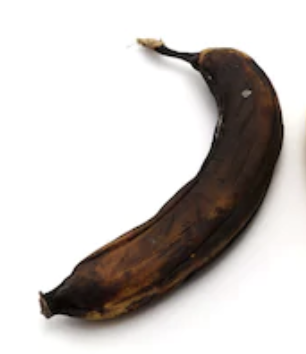

In [9]:
from PIL import Image
import torch.nn.functional as F

category_list = weights.meta['categories']

file_path = '/kaggle/input/apples-bananas-oranges/original_data_set/rottenbanana/Screen Shot 2018-06-12 at 8.50.04 PM.png'
image = Image.open(file_path).convert('RGB')
rotten_apple_tensor = transform(image)

rotten_apple_tensor.shape

resnet_model.eval() # use on inference if the model is using dropout OR batch normalization
with torch.inference_mode():
    logits = resnet_model(rotten_apple_tensor.reshape(1,3,224,224))
    probs = F.softmax(logits, dim=1)
    predicted_class = torch.argmax(probs)
    print(category_list[predicted_class.item()], probs.squeeze()[predicted_class].item())

image

# Fine tuning the pre-trained model

Replace and Retrain the final fully connected layer of the pre-trained model

In [10]:
# Freeze base model 
resnet_model.requires_grad_(False) # we dont want trainable gradients
next(iter(resnet_model.parameters())).requires_grad # this checks it worked.

False

In [11]:
# Inspect head of the model
resnet_model.fc # the last layer, we will replace this.

Linear(in_features=512, out_features=1000, bias=True)

In [12]:
import torch.nn as nn

# Change head of the model, adding a new hidden layer, take care of the 
# matching with the chosen loss function
resnet_model.fc = nn.Sequential(
    nn.Linear(in_features=512, out_features=512),
    nn.ReLU(),
    nn.Linear(in_features=512, out_features=6), #Here, we omit the LogSoftmax()
    # because we are using CrossEntropyLoss, which already has a call to LogSoftmax()
    # Note the 6 output features here it relates to our new class outputs:
    # freshapples, freshbananas,freshoranges, rottenapples, rottenbanana, rottenoranges
)

#Categorical Cross Entropy
loss_function = nn.CrossEntropyLoss()

In [13]:
resnet_model.fc
next(iter(resnet_model.fc.parameters())).requires_grad # we can see now our last layer is now trainable

True

In [14]:
# Add device to the GPU
resnet_model = resnet_model.to(device)

In [15]:
config_dict = {
    'learning_rate': 0.003, 
    'epochs': 7,
}

# This save the weights and biases the weight configuration
wandb.config.update(config_dict)

In [16]:
from torch.optim import Adam, AdamW

optimizer = AdamW(resnet_model.parameters(), lr=config_dict['learning_rate'])

## Create train, val and test sets

In [17]:
from torchvision import datasets
from torchvision.transforms import v2 as transforms

In [18]:
# Warning weird behaviour here
# Note there is a hidden folder original_data_set so we need to say it twice here in the path
# For this to work as expected.
data_path = '/kaggle/input/apples-bananas-oranges/original_data_set/original_data_set'

full_dataset = datasets.ImageFolder(data_path)

In [19]:
# We need to map these labels to the units in the output of the neural network
labels = sorted(os.listdir(data_path))
labels

['freshapples',
 'freshbanana',
 'freshoranges',
 'rottenapples',
 'rottenbanana',
 'rottenoranges']

In [20]:
# We need to map the labels units in the output of neural network.
label_mapping = {index:label for index, label in enumerate(labels)}
label_mapping

{0: 'freshapples',
 1: 'freshbanana',
 2: 'freshoranges',
 3: 'rottenapples',
 4: 'rottenbanana',
 5: 'rottenoranges'}

In [21]:
from torch.utils.data import random_split

# see to make the split reproducable

torch.manual_seed(42)

#set the proportionas for train, val, test

train_ratio = 0.7 
val_ratio = 0.15 # for hyperparameters -> we checkpoint the model here.
test_ratio = 0.15

# Get the total number of samples in the dataset
total_size = len(full_dataset)

# Calculate the sizes for each split
train_size = int(total_size * train_ratio)
val_size = int(total_size * val_ratio)
test_size = total_size - train_size - val_size

# Perform the split
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset,
    [train_size, val_size, test_size]
)

# Verify the sizes
print(f"Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")


Train set size: 1058
Validation set size: 226
Test set size: 228


In [22]:
image_datasets = {'train':train_dataset, 'val':val_dataset, 'test':test_dataset}

In [23]:
# Look at original transformations from base model
transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [24]:
## Define augmentation for the training set

train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(), # this is stochastic (see Random)
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225] )
])

# We dont want to add stochastic/random components to the val set ONLY the trainging set, as 
# it makes it hard to tell if your hyper parameter tuning is working or not. 

In [25]:
# apply transformations to the different sets
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = transform
test_dataset.dataset.transform = transform 

## Create Data Loaders

In [26]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False) # as we said before
# we dont want random behaviour in the eval set.

test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [27]:
dataloaders = { 'train': train_dataloader,
               'val': val_dataloader,
               'test': test_dataloader } 

In [28]:
images, labels = next(iter(train_dataloader))
images.shape, labels

(torch.Size([32, 3, 224, 224]),
 tensor([4, 4, 5, 4, 4, 0, 5, 4, 3, 0, 1, 2, 1, 2, 1, 2, 4, 0, 4, 3, 5, 4, 3, 4,
         4, 5, 2, 0, 5, 5, 5, 2]))

# Training Loop
### Lets train out model and look at validation loss via WanDB

In [29]:
from tqdm import tqdm 

best_val_loss = float('inf')
best_model_weights = resnet_model.state_dict()
train_losses = []
val_losses = []

for epoch in tqdm(range(config_dict['epochs'])):
    for phase in ['train', 'val']:
        if phase == 'train':
            # This makes BatchNormalization use the stats of the current batch 
            resnet_model.train()
        else:
            # This makes BatchNormalization use the stats learned during training
            resnet_model.eval()

        # This is for the current epoch 
        running_loss = 0.0
        running_correct_predictions = 0.0

        for inputs, labels in dataloaders[phase]:
           # Move the data to the GPU
           inputs = inputs.to(device)
           labels = labels.to(device)

           with torch.set_grad_enabled(phase=='train'):
               optimizer.zero_grad()
               logits = resnet_model(inputs)
               loss = loss_function(logits, labels)
               preds = torch.argmax(logits, dim=1)

               if phase == 'train':
                   loss.backward()
                   optimizer.step()

               running_loss += loss.item() * inputs.size(0)
               running_correct_predictions += torch.sum(preds == labels.data).item()

        epoch_loss = running_loss / len(image_datasets[phase])
        epoch_accuracy = running_correct_predictions / len(image_datasets[phase])

        if phase == 'train':
            train_losses.append(epoch_loss)

        if phase == 'val':
            val_losses.append(epoch_loss)
            if epoch_loss < best_val_loss:
                print('New best model found')
                best_model_weights = resnet_model.state_dict()
                best_val_loss = epoch_loss

        print(f"epoch {epoch} {phase} loss: {epoch_loss:.3f}, accuracy: {epoch_accuracy:.2f}")

        wandb.log({
            'epoch' : epoch,
            f'{phase}_loss': epoch_loss,
            f'{phase}_accuracy': epoch_accuracy,
        })

torch.save(best_model_weights, 'best_model.pth')

  0%|          | 0/7 [00:00<?, ?it/s]

epoch 0 train loss: 0.614, accuracy: 0.79


 14%|█▍        | 1/7 [00:15<01:32, 15.44s/it]

New best model found
epoch 0 val loss: 0.164, accuracy: 0.93
epoch 1 train loss: 0.169, accuracy: 0.94


 29%|██▊       | 2/7 [00:25<01:00, 12.17s/it]

epoch 1 val loss: 0.252, accuracy: 0.88
epoch 2 train loss: 0.319, accuracy: 0.89


 43%|████▎     | 3/7 [00:35<00:44, 11.07s/it]

New best model found
epoch 2 val loss: 0.123, accuracy: 0.95
epoch 3 train loss: 0.074, accuracy: 0.98


 57%|█████▋    | 4/7 [00:44<00:31, 10.59s/it]

epoch 3 val loss: 0.209, accuracy: 0.92
epoch 4 train loss: 0.131, accuracy: 0.96


 71%|███████▏  | 5/7 [00:54<00:20, 10.30s/it]

epoch 4 val loss: 0.189, accuracy: 0.94
epoch 5 train loss: 0.242, accuracy: 0.92


 86%|████████▌ | 6/7 [01:04<00:10, 10.08s/it]

New best model found
epoch 5 val loss: 0.117, accuracy: 0.96
epoch 6 train loss: 0.113, accuracy: 0.96


100%|██████████| 7/7 [01:14<00:00, 10.60s/it]

New best model found
epoch 6 val loss: 0.105, accuracy: 0.96


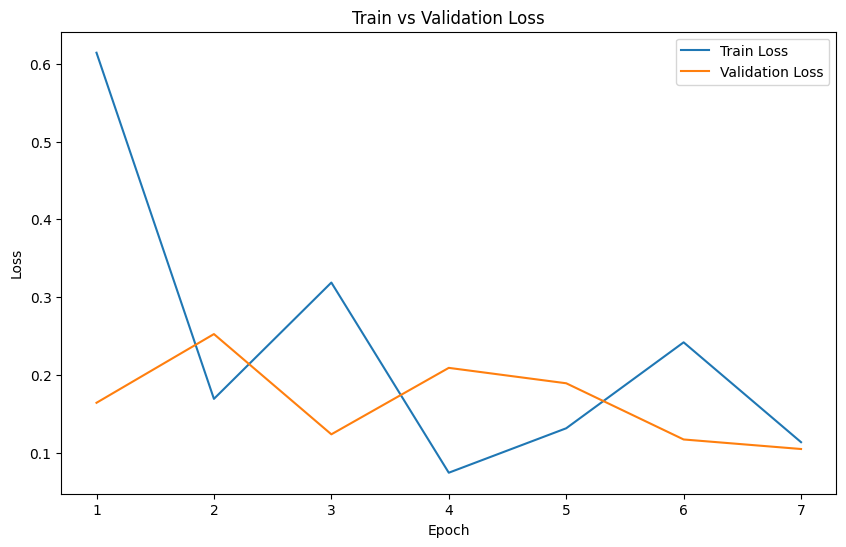

<Artifact training_plots>

In [30]:
import matplotlib.pyplot as plt
# Create and save the plot first
plt.figure(figsize=(10, 6))
plt.plot(range(1, config_dict['epochs'] + 1), train_losses, label='Train Loss')
plt.plot(range(1, config_dict['epochs'] + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.savefig('/kaggle/working/train_val_loss.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# Create an artifact for the plot
plot_artifact = wandb.Artifact(
    'training_plots', 
    type='plot',
    description='Training and validation loss curves'
)

# Add the plot file to the artifact
plot_artifact.add_file('/kaggle/working/train_val_loss.png')

# Save to W&B and log the artifact
wandb.save('/kaggle/working/train_val_loss.png', base_path='/kaggle')
wandb.log_artifact(plot_artifact)

## Save our trained weights to WanDB

In [31]:
model_artifact = wandb.Artifact(
    'resnet18', 
    type='model',
    description='trained on apples-bananas-oranges dataset'
)
model_artifact.add_file('/kaggle/working/best_model.pth')
wandb.save('/kaggle/working/best_model.pth', base_path='/kaggle')
wandb.log_artifact(model_artifact)

<Artifact resnet18>

In [32]:
wandb.finish()


epoch,▁▁▂▂▃▃▅▅▆▆▇▇██
train_accuracy,▁▆▅█▇▆▇
train_loss,█▂▄▁▂▃▂
val_accuracy,▅▁▇▄▆██
val_loss,▄█▂▆▅▂▁
epoch,6
train_accuracy,0.9603
train_loss,0.11337
val_accuracy,0.96018
val_loss,0.10459


## Save Baseline Resnet to WanDB for comparison

In [33]:
torch.save(resnet_model, 'resnet_basemodel.pth')

In [35]:
model_artifact = wandb.Artifact(
    'resnet18', 
    type='model',
    description='standard resent18 basemodel'
)
model_artifact.add_file('/kaggle/working/resnet_basemodel.pth')
wandb.init()
wandb.save('/kaggle/working/resnet_basemodel.pth', base_path='/kaggle')
wandb.log_artifact(model_artifact)

<Artifact resnet18>

In [36]:
wandb.finish()
